# Multinomial Naive Bayes Classifier for News Category Classification

## Introduction
This project implements a **Multinomial Naive Bayes** classifier from scratch for classifying news articles into categories based on text data. We use a dataset containing news headlines and short descriptions, and process the data to predict each article's category. 

The classifier is based on the **Naive Bayes** theorem, which models the probability of a class given a set of features under the assumption that features are conditionally independent.

### Naive Bayes Formula
Given a text $ X = (x_1, x_2, \dots, x_n) $ with features (words) $ x_i $, we calculate the probability of a class $ y $ as:
$$
P(y \mid X) \propto P(y) \prod_{i=1}^n P(x_i \mid y)
$$

where:
- $ P(y) $ is the prior probability of class $ y $,
- $ P(x_i \mid y) $ is the likelihood of feature $ x_i $ given class $ y $.

Our goal is to maximize $ P(y \mid X) $ to classify $ X $ into the most likely category $ y $.

In [1]:
# Import necessary libraries
import json
import matplotlib.pyplot as plt
import multiprocessing
import numpy as np
import pandas as pd
import seaborn as sns
from collections import defaultdict, Counter
from concurrent.futures import ProcessPoolExecutor
from scipy.sparse import csr_matrix
from scipy.sparse import hstack
from scipy.sparse import lil_matrix
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer

# Load data from JSON file
data = []
with open('data/News_Category_Dataset_v3.json', 'r') as f:
    for line in f:
        data.append(json.loads(line.strip()))

# Convert the data to a DataFrame
df = pd.DataFrame(data)
df['text'] = df['headline']  # Combine headline and short description
df = df[['text', 'category', 'authors']]  # Keep only the text, authors and category columns for simplicity

# Clean up the data
df['category'] = df['category'].replace('WORLDPOST','WORLD NEWS')
df['category'] = df['category'].replace('THE WORLDPOST','WORLD NEWS')
df['category'] = df['category'].replace('ARTS', 'ARTS & CULTURE')
df['category'] = df['category'].replace('STYLE', 'STYLE & BEAUTY')
df['category'] = df['category'].replace('PARENTS', 'PARENTING')

# Handle missing authors
df['authors'] = df['authors'].fillna('Unknown')
# Split authors by comma and strip whitespace
df['authors'] = df['authors'].apply(lambda x: [author.strip() for author in x.split(',')])

df.head()

,text,category,authors
0,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,"[Carla K. Johnson, AP]"
1,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,[Mary Papenfuss]
2,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,[Elyse Wanshel]
3,The Funniest Tweets From Parents This Week (Se...,PARENTING,[Caroline Bologna]
4,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,[Nina Golgowski]


## Data Overview
To better understand our dataset, we will visualize the distribution of categories. This helps us check for class imbalance, which could affect the classifier's performance.

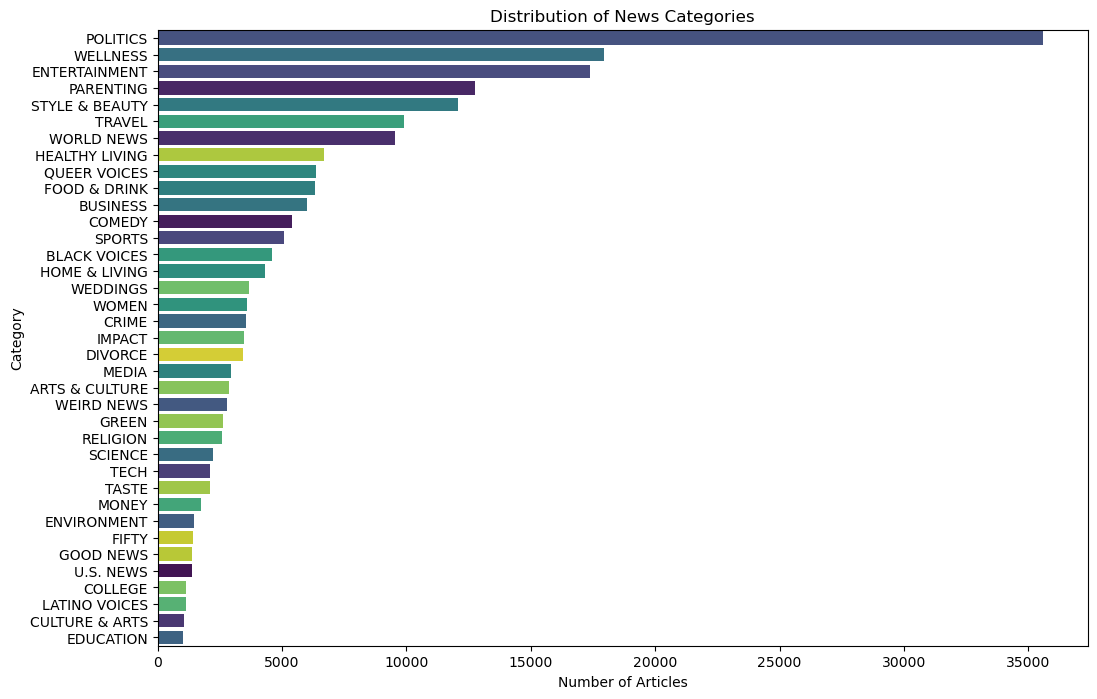

In [2]:
plt.figure(figsize=(12, 8))
sns.countplot(
    y='category', 
    data=df, 
    order=df['category'].value_counts().index, 
    palette='viridis', 
    hue='category',
    dodge=False,
    legend=False
)
plt.title('Distribution of News Categories')
plt.xlabel('Number of Articles')
plt.ylabel('Category')
plt.show()

## Text Preprocessing and Vectorization
For the Naive Bayes classifier to work with text data, the text must first be transformed into a numerical format. Here, we use **TfidfVectorizer** to convert text into a matrix of TF-IDF scores, which represent the importance of each word within each document. 

### What is TF-IDF?
TF-IDF stands for **Term Frequency-Inverse Document Frequency**, a technique that reflects how important a word is in a document relative to a collection of documents (corpus). It balances two main components:

1. **Term Frequency (TF):** Measures how frequently a term appears in a document. Higher frequency suggests more relevance to the document. 
   
$$
\text{TF}(t,d) = \frac{\text{Count of term } t \text{ in document } d}{\text{Total terms in document } d}
$$

2. **Inverse Document Frequency (IDF):** Measures how unique or rare a term is across all documents in the corpus. Words that appear in many documents receive a lower weight, while words that are unique to a few documents have higher weights.
   
$$
\text{IDF}(t) = \log\left(\frac{M + 1}{\text{Number of documents containing } t} + 1\right)
$$
   
where $ M $ is the total number of documents. Adding 1 to both the numerator and denominator helps smooth the score, especially for terms that may appear in all or no documents.

The final **TF-IDF score** for each term $ t $ in document $ d $ is then computed as:

$$
\text{TF-IDF}(t, d) = \text{TF}(t, d) \times \text{IDF}(t)
$$

### Matrix Dimensions
After applying TF-IDF vectorization, the resulting matrix has dimensions $ M \times N $, where:
- $ M $ is the number of documents (articles),
- $ N $ is the vocabulary size (unique words after removing common stopwords).

In this matrix, each entry represents the TF-IDF score of a word in a specific document, providing a numerical representation of text that the Naive Bayes classifier can use for training and prediction. By removing common English stopwords, we focus on words that are more meaningful and distinctive in each document.

In [3]:
# Vectorize the text (headline) using CountVectorizer
vectorizer = TfidfVectorizer(stop_words='english')
X_text = vectorizer.fit_transform(df['text'])

# One-hot encode the authors using MultiLabelBinarizer (this handles multiple authors)
author_encoder = MultiLabelBinarizer(sparse_output=True)
X_authors = author_encoder.fit_transform(df['authors'])

# Combine both the text features and author features
X_combined = hstack([X_text, X_authors], format='csr')

y = df['category'].values

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

## Naive Bayes Model - Prior and Likelihood Calculation

The Naive Bayes model requires calculating **prior probabilities** and **likelihoods**.

### Prior Probability $ P(y) $
For each category $ y $, the prior probability is:
$$
P(y) = \frac{\text{Number of documents in } y}{\text{Total number of documents}}
$$

### Likelihood with Laplace Smoothing $ P(x_i \mid y) $
For each word $ x_i $ in category $ y $, the likelihood with Laplace smoothing is:
$$
P(x_i \mid y) = \frac{\text{Count of } x_i + \alpha}{\text{Total words in } y + \alpha \times \text{Vocabulary size}}
$$
where $ \alpha $ is a smoothing parameter to handle zero probabilities.

In [4]:
# Calculate prior probabilities for each category
class_counts = Counter(y_train)
total_documents = len(y_train)

# Inverse frequency for priors, so rare classes get more weight
inverse_class_freq = {cls: 1 / count for cls, count in class_counts.items()}
sum_inverse_freq = sum(inverse_class_freq.values())

# Normalize to get probabilities (priors)
prior_probs = {cls: inverse_class_freq[cls] / sum_inverse_freq for cls in inverse_class_freq}

prior_probs

{'POLITICS': 0.002057126553027211,
 'ENTERTAINMENT': 0.004197022093808009,
 'WORLD NEWS': 0.007697853072081699,
 'CRIME': 0.020540217288159027,
 'TRAVEL': 0.0074272216085753354,
 'COMEDY': 0.013366623813148714,
 'STYLE & BEAUTY': 0.006077378653439098,
 'PARENTING': 0.00574674251732938,
 'IMPACT': 0.020817886536451467,
 'TECH': 0.03430192207149183,
 'WELLNESS': 0.004099984520000355,
 'SPORTS': 0.014402923714980326,
 'FOOD & DRINK': 0.011542224665476346,
 'GREEN': 0.02799955935596415,
 'BUSINESS': 0.012252738495386321,
 'ARTS & CULTURE': 0.025666262742967138,
 'HEALTHY LIVING': 0.010852944928405986,
 'MEDIA': 0.025040256334602086,
 'QUEER VOICES': 0.01150817680510621,
 'BLACK VOICES': 0.015841656484560117,
 'WEDDINGS': 0.01987740456996096,
 'WOMEN': 0.02056909632828298,
 'ENVIRONMENT': 0.05174100712110086,
 'DIVORCE': 0.02118721182257968,
 'CULTURE & ARTS': 0.06710903561234527,
 'RELIGION': 0.028587727920842732,
 'HOME & LIVING': 0.017006416464389735,
 'SCIENCE': 0.03283898936810611,
 'L

In [5]:
# TODO: parallelize this
# Count word occurrences in each class
word_counts = defaultdict(lambda: np.zeros(X_train.shape[1]))
    
for i, category in enumerate(y_train):
    word_counts[category] += X_train[i].toarray().flatten()

total_words = {cls: np.sum(word_counts[cls]) for cls in class_counts}

In [6]:
# Function to calculate likelihood with Laplace smoothing
def calculate_likelihood(word_idx, category, alpha=1.0):
    return (word_counts[category][word_idx] + alpha) / (total_words[category] + alpha * X_train.shape[1])

In [7]:
def predict(X_test_row):
    # Vectorize the input text
    x = X_test_row.toarray().flatten()
    
    # Calculate posterior probability for each category
    posteriors = {}
    for category in class_counts:
        # Start with the prior
        posteriors[category] = np.log(prior_probs[category])
        
        # Add the log likelihood of each word in the text
        for idx in np.where(x > 0)[0]:
            posteriors[category] += x[idx] * np.log(calculate_likelihood(idx, category))
    
    # Return the category with the highest posterior probability
    return max(posteriors, key=posteriors.get)

# Parallelize prediction using multiprocessing
def parallel_predict(X_test, num_processes=None):
    with multiprocessing.Pool(processes=num_processes) as pool:
        predictions = pool.map(predict, [X_test[i] for i in range(X_test.shape[0])])
    
    return predictions

In [8]:
# Predict categories for each text in the test set
predictions = parallel_predict(X_test)

# Generate the classification report
print("Classification Report:")
print(classification_report(y_test, predictions))

Classification Report:
                precision    recall  f1-score   support

ARTS & CULTURE       0.80      0.69      0.74       568
  BLACK VOICES       0.70      0.50      0.58       889
      BUSINESS       0.69      0.57      0.63      1216
       COLLEGE       0.36      0.56      0.44       202
        COMEDY       0.56      0.66      0.61      1022
         CRIME       0.45      0.66      0.54       713
CULTURE & ARTS       0.39      0.49      0.43       202
       DIVORCE       0.64      0.80      0.71       664
     EDUCATION       0.23      0.63      0.34       209
 ENTERTAINMENT       0.78      0.77      0.77      3419
   ENVIRONMENT       0.43      0.45      0.44       313
         FIFTY       0.40      0.73      0.52       263
  FOOD & DRINK       0.84      0.86      0.85      1270
     GOOD NEWS       0.41      0.59      0.48       270
         GREEN       0.51      0.41      0.46       532
HEALTHY LIVING       0.68      0.59      0.63      1302
 HOME & LIVING       0.8

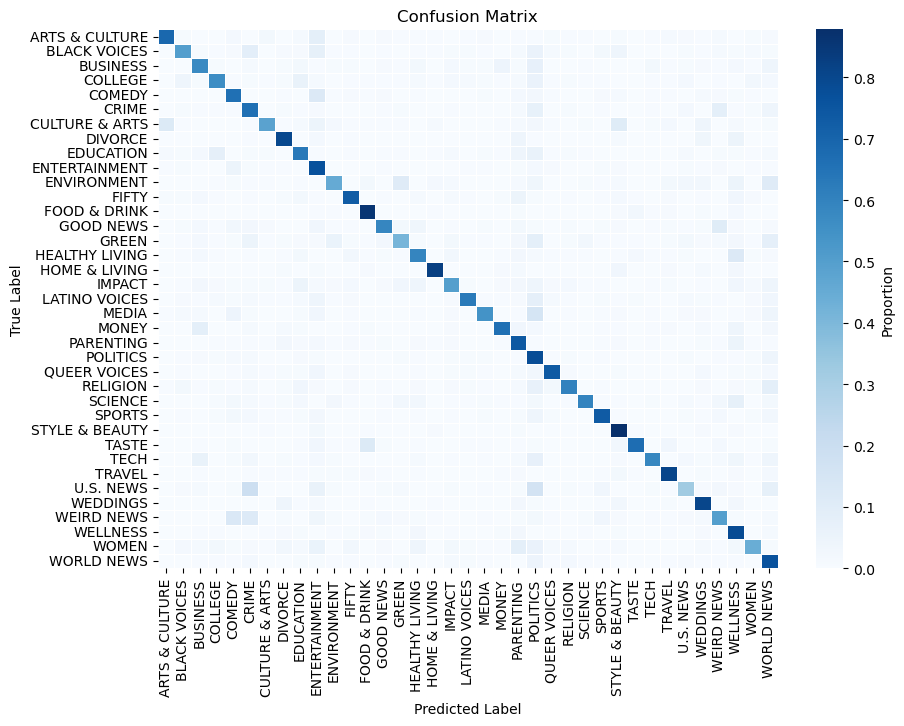

In [9]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, predictions)

# Normalize the confusion matrix (by rows) to account for class imbalance
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 7))

sns.heatmap(cm_normalized, annot=False, fmt='.2f', cmap='Blues', 
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test), 
            cbar_kws={'label': 'Proportion'}, linewidths=0.5)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## Bibligraphy

1. [Misra, Rishabh. "News Category Dataset." arXiv preprint arXiv:2209.11429 (2022).](https://arxiv.org/abs/2209.11429)
3. [Ratz, Arthur. "Multinomial Naїve Bayes’ For Documents Classification and Natural Language Processing (NLP).", Towards Data Science, May 17, 2021.](https://towardsdatascience.com/multinomial-na%C3%AFve-bayes-for-documents-classification-and-natural-language-processing-nlp-e08cc848ce6) 
4. [Kavlakoglu, Eda. "Classifying data using the Multinomial Naive Bayes algorithm.", IBM Developer, March 19, 2024.](https://developer.ibm.com/tutorials/awb-classifying-data-multinomial-naive-bayes-algorithm/)
5. ["tf-idf." Wikipedia, The Free Encyclopedia. Retrieved November 13, 2024, from https://en.wikipedia.org/wiki/Tf-idf.](https://en.wikipedia.org/wiki/Tf%E2%80%93idf)